In [4]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from numpy import log
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.iolib.table import SimpleTable
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
from numpy import log

import ml_metrics as metrics

import matplotlib.pyplot as plt

from pmdarima import auto_arima

In [2]:
seriesDF = pd.read_json("tsData.json")

In [3]:
seriesDF.head()

,cnt
2022-03-20 03:00:00,2798
2022-03-20 03:00:01,3344
2022-03-20 03:00:02,2417
2022-03-20 03:00:03,2171
2022-03-20 03:00:04,2135


In [4]:
desc = seriesDF.describe()
desc

,cnt
count,518401.000000
mean,2947.208671
std,1449.496324
min,83.000000
25%,2237.000000
50%,2608.000000
75%,3479.000000
max,26354.000000


array([[<AxesSubplot:title={'center':'cnt'}>]], dtype=object)

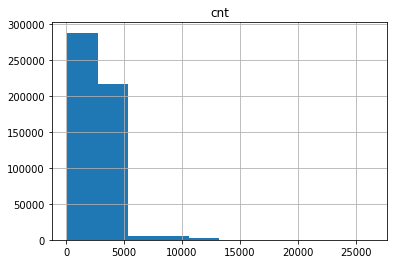

In [44]:
seriesDF.hist()

<AxesSubplot:>

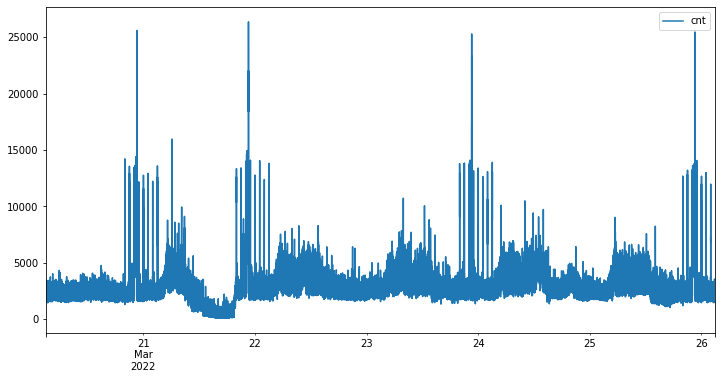

In [5]:
seriesDF.plot(figsize=(12,6))

In [4]:
test = sm.tsa.adfuller(seriesDF[:"2022-03-22 03:00:00"])
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -10.705960108824383
p-value:  3.4273147875026052e-19
Critical values:  {'1%': -3.4303878608236804, '5%': -2.8615567339685435, '10%': -2.5667789068923654}
единичных корней нет, ряд стационарен


In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.000000


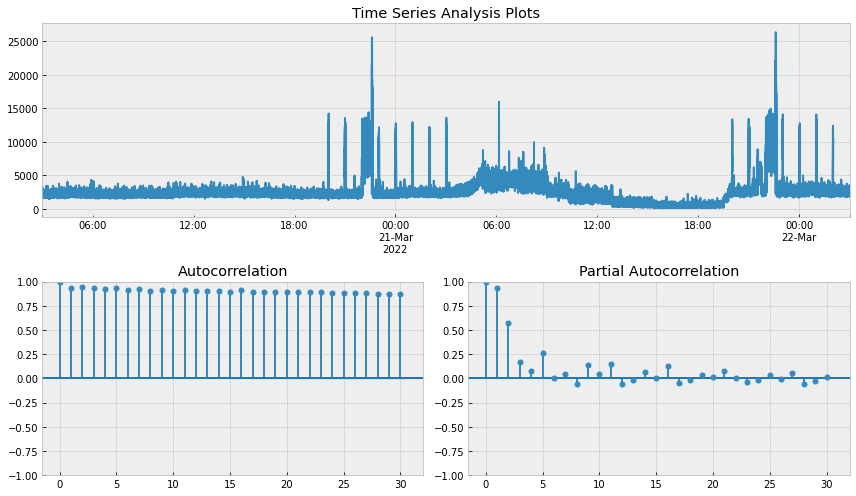

In [6]:
tsplot(seriesDF.cnt[:"2022-03-22 03:00:00"], lags=30)

In [13]:
seriedDF_diff = (seriesDF.cnt[:"2022-03-22 03:00:00"]).diff()
seriedDF_diff = seriedDF_diff.dropna()

Критерий Дики-Фуллера: p=0.000000


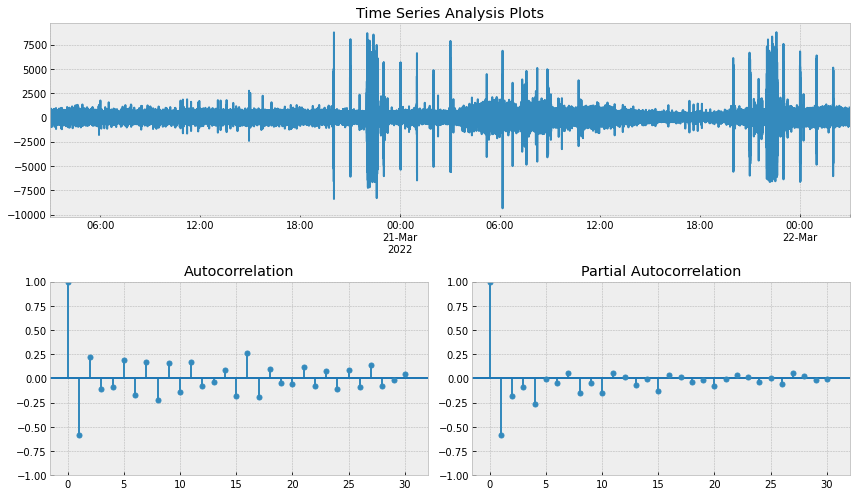

In [14]:
tsplot(seriedDF_diff, lags=30)

In [16]:
trainDF = seriesDF[:"2022-03-21 6:00:00"]
stepwise_fit = auto_arima(trainDF, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1458353.595, Time=147.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1509608.979, Time=3.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1467863.281, Time=7.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1462244.702, Time=31.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1509606.979, Time=1.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1459752.988, Time=30.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1458418.474, Time=108.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1455615.642, Time=107.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1458332.058, Time=133.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1454821.850, Time=85.99 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1456103.133, Time=31.90 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1454230.821, Time=70.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1454893.867, Time=119.28 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=145

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                97201
Model:               SARIMAX(5, 1, 4)   Log Likelihood             -724675.837
Date:                Mon, 31 Oct 2022   AIC                        1449371.675
Time:                        17:27:29   BIC                        1449466.520
Sample:                    03-20-2022   HQIC                       1449400.495
                         - 03-21-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0512      0.002     30.217      0.000       0.048       0.055
ar.L2          0.0518      0.002     34.231      0.000       0.049       0.055
ar.L3         -0.6277      0.001   -446.191      0.000      -0.630      -0.625
ar.L4          0.1427      0.001    146.816      0.000       0.141       0.145
ar.L5          0.4408      0.001    405.024      0.000       0.439       0.443
ma.L1         -0.8324      0.002   -458.684      0.000      -0.836      -0.829
ma.L2          0.2576      0.002    105.734      0.000       0.253       0.262
ma.L3          0.4767      0.002    193.048      0.000       0.472       0.482
ma.L4         -0.7068      0.001   -519.458      0.000      -0.709      -0.704
sigma2      1.814e+05    194.234    933.703      0.000    1.81e+05    1.82e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.54   Jarque-Bera (JB):           6982490.97
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               6.68   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
trainDF = seriesDF[:"2022-03-21 6:00:00"]

In [18]:
model = sm.tsa.ARIMA(trainDF, order=(5,1,4)).fit()

In [49]:
test = seriesDF["2022-03-21 6:00:01": "2022-03-21 7:00:00"]
start = len(trainDF)
end = len(trainDF) + len(test) -1
pred = model.predict(start=start, end=end, typ='levels')
pred.index = seriesDF.index[start: end+1]

In [50]:
print(pred)

2022-03-21 06:00:01    4640.263592
2022-03-21 06:00:02    4623.757873
2022-03-21 06:00:03    4639.311357
2022-03-21 06:00:04    4594.163347
2022-03-21 06:00:05    4646.139629
                          ...     
2022-03-21 06:59:56    4587.125164
2022-03-21 06:59:57    4587.125164
2022-03-21 06:59:58    4587.125164
2022-03-21 06:59:59    4587.125164
2022-03-21 07:00:00    4587.125164
Name: predicted_mean, Length: 3600, dtype: float64


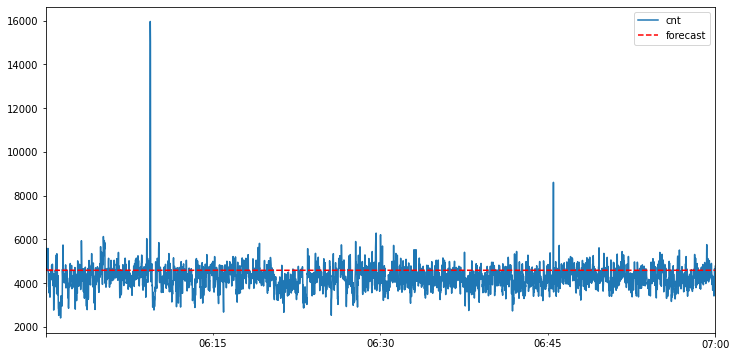

In [54]:
test.plot(figsize=(12,6))
pred.plot(style='r--', label='forecast')
plt.legend(loc='best')

In [84]:
r2 = r2_score(test, pred)
print('R^2: %1.2f' % r2)

R^2: -0.33


In [52]:
metrics.rmse(test, pred)

661.7781226664812

In [53]:
metrics.mae(test, pred)

481.08240492244005

# Short term prediction

In [13]:
data = []
train = seriesDF[0:1000]
for i in tqdm(range(100)):
    model = sm.tsa.ARIMA(train[i:i+5], order=(1,1,1)).fit()
    test = seriesDF[i+5:i+5+1]
    start = len(train[i:i+5])
    end = len(train[i:i+5]) + len(test) -1
    pred = model.predict(start=start, end=end, typ='levels')
    data.append((pred.index[0], pred[0]))

predicted = pd.DataFrame(data, columns=['data', 'cnt'])
predicted.index = preficted["data"]
del predicted["data"]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


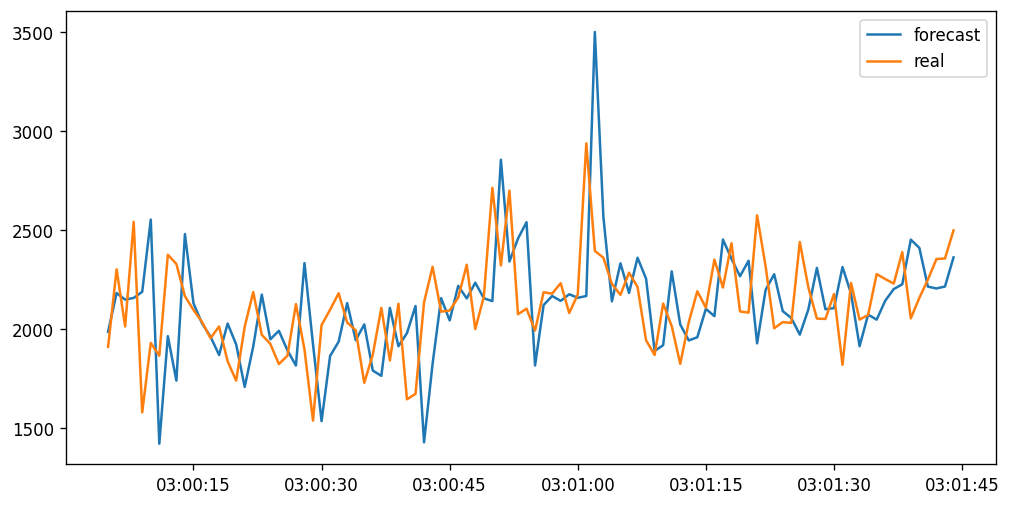

In [14]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.plot(predicted.index, predicted, label='forecast')
plt.plot(train[5:105].index, train[5:105], label='real')
plt.legend()

In [31]:
r2 = r2_score(train[5:105], df)
print('R^2: %1.2f' % r2)

R^2: -0.74


In [32]:
metrics.rmse(train[5:105], df)

307.46538903044615

In [33]:
metrics.mae(train[5:105], df)

234.14509423259398

# resample

<AxesSubplot:>

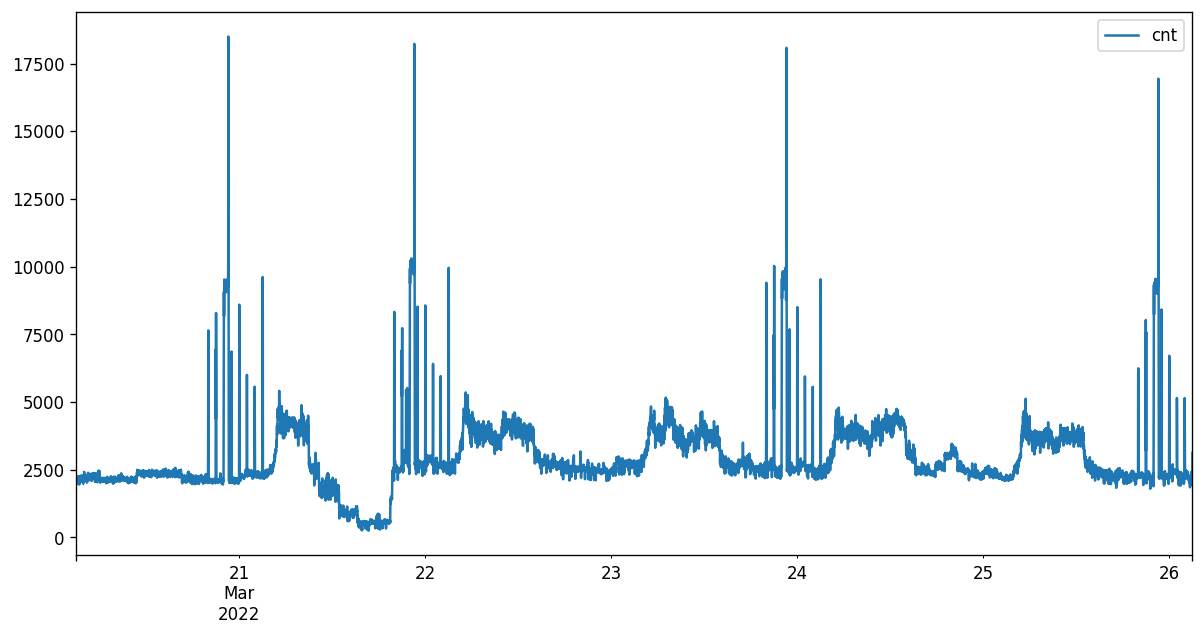

In [15]:
series = seriesDF.resample('1Min').mean()
series.plot(figsize=(12,6))

In [30]:
test = sm.tsa.adfuller(series)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -10.249527518643465
p-value:  4.523963111030733e-18
Critical values:  {'1%': -3.431110345490302, '5%': -2.861876021468662, '10%': -2.566948859294898}
единичных корней нет, ряд стационарен


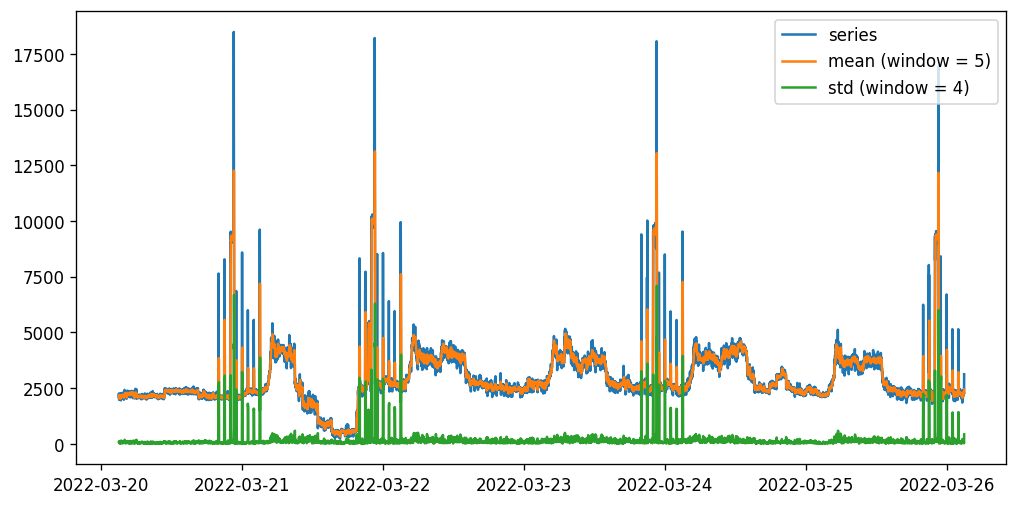

In [29]:
plt.figsize=(12,6)
plt.plot(series, label='series')
plt.plot(series.rolling(window=5).mean(), label='mean (window = 5)')
plt.plot(series.rolling(window=4).std(), label='std (window = 4)')
plt.legend(loc='upper right')

In [93]:
data = []
anomalies = []
train = series[0:8640]
for i in tqdm(range(8630)):
    model = sm.tsa.ARIMA(train[i:i+5], order=(1,1,1)).fit()
    test = seriesDF[i+5:i+5+1]
    start = len(train[i:i+5])
    end = len(train[i:i+5]) + len(test) -1
    pred = model.predict(start=start, end=end, typ='levels')
    data.append((pred.index[0], pred[0]))
    #print(float(train[str(pred.index[0]):str(pred.index[0])].cnt))
    if abs(pred[0] - float(train[str(pred.index[0]):str(pred.index[0])].cnt)) > 0.25 * abs(pred[0]):
        anomalies.append((pred.index[0], pred[0]))
        

predicted = pd.DataFrame(data, columns=['date', 'cnt'])
predicted.index = predicted["date"]
del predicted["date"]

anomaliesDF = pd.DataFrame(anomalies, columns=['date', 'cnt'])
anomaliesDF.index = anomaliesDF["date"]
del anomaliesDF["date"]

100%|██████████████████████████████████████████████████████████████████████████████| 8630/8630 [22:02<00:00,  6.52it/s]


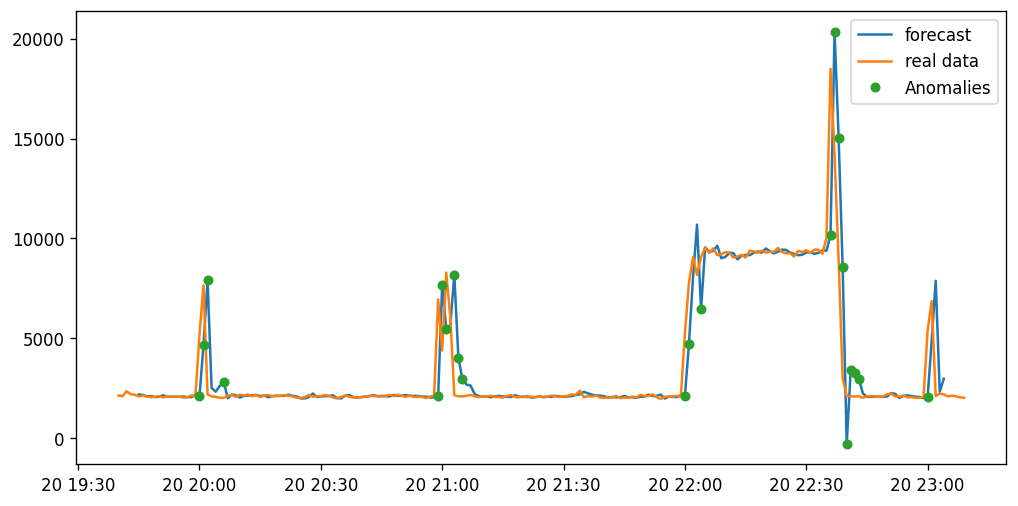

In [97]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.plot(predicted.index[1000:1200], predicted[1000:1200], label='forecast')
plt.plot(train[1000:1210].index, train[1000:1210], label='real data')
plt.plot(anomaliesDF["2022-03-20 19:30:00":"2022-03-20 23:00:00"], "o", markersize=5, label = "Anomalies")
plt.legend()

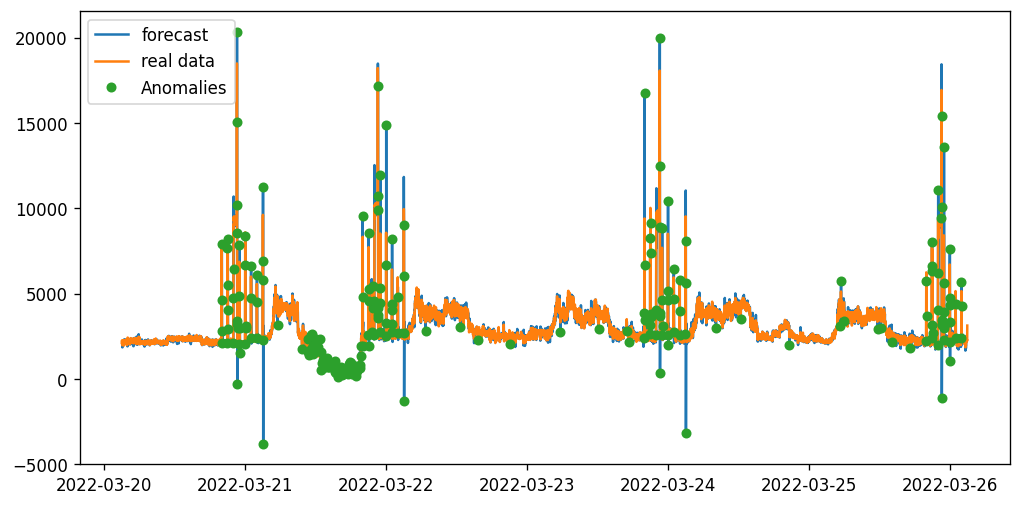

In [96]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plt.plot(predicted.index, predicted, label='forecast')
plt.plot(series.index, series, label='real data')
plt.plot(anomaliesDF, "o", markersize=5, label = "Anomalies")
plt.legend()

In [94]:
anomaliesDF

,cnt
date,
2022-03-20 20:00:00,2090.524765
2022-03-20 20:01:00,4654.055392
2022-03-20 20:02:00,7904.203860
2022-03-20 20:06:00,2803.548107
2022-03-20 20:59:00,2085.149958
...,...
2022-03-26 01:00:00,2413.489048
2022-03-26 01:02:00,4363.613849
2022-03-26 02:00:00,2418.499934


In [98]:
len(anomaliesDF)/len(series)

0.03055201944219419

In [99]:
len(anomaliesDF)/len(seriesDF)

0.000509258276893756